In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
warnings.filterwarnings('ignore')

<h1 align=center><font size = 5 color='blue'>Chargement et préparation des données</font></h1>

In [ ]:
data=pd.read_csv('../data/yelp-text-by-stars.csv',sep=';',encoding="ISO-8859-1")
data.head(3)

,Stars,Text
0,1,Boarded my English Mastiff here over New Year'...
1,1,Another case of the Emperor's New Clothes. So...
2,1,Came on Valentine's Day night having pre-bough...


In [ ]:
corpus = data.iloc[:, 1].values  # Extract text data
Y = data.iloc[:, 0].values  # Extract target values

In [ ]:
data.info

In [ ]:
import matplotlib.pyplot as plt



# Data analysis and visualization

# Analyzing the distribution of the 'Stars' column
star_distribution = data['Stars'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
star_distribution.plot(kind='bar')
plt.title('Distribution of Review Stars')
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()


In [ ]:
 # Basic Statistical Analysis
 stars_description = data['Stars'].describe()
 stars_description

In [ ]:
print('Taille du corpus : {0:d}'.format(len(corpus)))

Taille du corpus : 47371


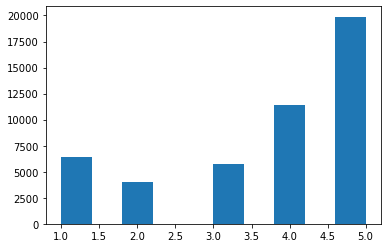

In [ ]:
# Histogram of the target variable 'Y'
plt.hist(Y)
plt.show()

**Nettoyage et prétraitement du texte :**

Preprocesses the input text by performing lowercasing, removing punctuation, numbers,
    extra spaces, tokenizing, removing stopwords, and applying lemmatization.

In [ ]:
# Fonction de nettoyage de texte
def clean_text(text):
    text = text.lower()  # Convertir en minuscule
    text = re.sub(r'\W', ' ', text)  # Suppression de la ponctuation
    text = re.sub(r'\s+', ' ', text)  # Suppression des espaces supplémentaires
    text = re.sub(r'http\S+', '', text)  # Suppression des URLs
    return text

In [ ]:

# Application du nettoyage
data['Cleaned_Text'] = data['Text'].apply(clean_text)

In [ ]:
# Suppression des stopwords et lemmatisation
stop_words = set(stopwords.words('english')) # Set of English stopwords
lemmatizer = WordNetLemmatizer() # Initialize lemmatizer

In [ ]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text) # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]# Lemmatize tokens
    return ' '.join(tokens)

In [ ]:
# Application de la prétraitement
data['Preprocessed_Text'] = data['Cleaned_Text'].apply(preprocess_text)

### Découpage de la base en Apprentissage et test

In [ ]:
corpus_train,corpus_test,y_train,y_test=train_test_split(corpus,Y,test_size=0.33,shuffle=True,random_state=1)

<h1 align=center><font size = 5 color='blue'>Création des modèles d'apprentissage</font></h1>

In [ ]:
# Définition d'un dictionnaire contenant différents algorithmes d'apprentissage automatique

algos = {
'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
 'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=200,random_state=1,alpha=0.001)
}
# Définition d'une fonction run_models pour entraîner et évaluer les modèles
def run_models(X_train, Y_train, X_test, Y_test, algos):
    # Boucle à travers les noms des algorithmes
    for algo_name in algos:
        model = algos[algo_name]  # Sélection du modèle à partir du dictionnaire
        model.fit(X_train, Y_train)  # Entraîner le modèle sur les données d'entraînement
        prediction = model.predict(X_test)  # Effectuer des prédictions sur les données de test
        prediction[prediction < 1] = 1  # Assurer que les prédictions sont dans la plage [1, 5]
        prediction[prediction > 5] = 5
        MAE = mean_absolute_error(Y_test, prediction)  # Calcul de l'erreur absolue moyenne
        ACC = accuracy_score(Y_test, np.round(prediction))  # Calcul de l'exactitude

        # Affichage des résultats
        print('################## {0} #############'.format(algo_name))
        print('MAE = {0:.3f}, Accuracy = {1:.3f}'.format(MAE, ACC))
        display(confusion_matrix(Y_test, np.round(prediction)))  # Affichage de la matrice de confusion
        print()


<h1 align=center><font size = 5 color='blue'>Vectorisation des textes par TF-IDF</font></h1>

1-CountVectorizer for Bag-of-Words (BoW) Model:


In [ ]:


# Initializing the CountVectorizer with a maximum of 1000 features and excluding English stop words
bow_vectorizer = CountVectorizer(max_features=1000, stop_words='english')

# Transforming the training corpus into BoW vectors
bow_train = bow_vectorizer.fit_transform(corpus_train)

# Transforming the test corpus into BoW vectors using the same vectorizer
bow_test = bow_vectorizer.transform(corpus_test)

# Running various models with the BoW vectors of the training and test sets
run_models(bow_train.toarray(), y_train, bow_test.toarray(), y_test, algos)


2.TfidfVectorizer for TF-IDF Model:

In [ ]:


# Initializing the TfidfVectorizer with a maximum of 1000 features and excluding English stop words
TFIDF = TfidfVectorizer(max_features=1000, stop_words='english')

# Fitting the vectorizer to the training corpus
TFIDF.fit(corpus_train)

# Transforming the training corpus into TF-IDF vectors
corpus_train_tfidf = TFIDF.transform(corpus_train)

# Transforming the test corpus into TF-IDF vectors using the same vectorizer
corpus_test_tfidf = TFIDF.transform(corpus_test)


3-Displaying Transformed Text and Vocabulary:

In [ ]:
corpus_train_tfidf[0].toarray() # Pour afficher le premier texte transformé par TFIDF

In [ ]:
CV.vocabulary_ # Pour afficher le vocabulaire gardé par TFIDF

In [ ]:
TFIDF.get_feature_names()[17]  # Pour afficher le 18eme mot du vocabulaire

4-Extending Stop Words List:

In [ ]:
# pour compléter la liste des stop words par défaut de sklearn

from sklearn.feature_extraction import _stop_words
_stop_words.ENGLISH_STOP_WORDS
new_stop_words=_stop_words.ENGLISH_STOP_WORDS.union(frozenset({'30','40'}))



5-Running Models with TF-IDF Vectors:

In [ ]:
# Run models with TF-IDF vectors
run_models (corpus_train_tfidf.toarray(),y_train,corpus_test_tfidf.toarray(),y_test,algos)

################## RF #############
MAE = 0.735, Accuracy =0.457


array([[ 587,  841,  472,  221,   23],
       [  78,  405,  514,  337,   44],
       [  34,  213,  722,  822,   96],
       [   8,  104,  612, 2217,  720],
       [   8,  104,  456, 2779, 3216]])


################## KNN #############
MAE = 0.918, Accuracy =0.361


array([[ 271,  632,  707,  440,   94],
       [  62,  242,  507,  496,   71],
       [  28,  153,  600,  931,  175],
       [   9,  105,  756, 2049,  742],
       [  16,  133,  921, 3013, 2480]])


################## MLP #############
MAE = 0.752, Accuracy =0.507


array([[1250,  445,  202,  141,  106],
       [ 371,  361,  302,  224,  120],
       [ 167,  339,  468,  589,  324],
       [ 114,  255,  511, 1311, 1470],
       [ 141,  234,  377, 1270, 4541]])

<h1 align=center><font size = 5 color='blue'>Sélection de mots clés pertinents</font></h1>

['great' 'worst' 'told' 'amazing' 'best' 'rude' 'horrible' 'delicious'
 'love' 'good' 'friendly' 'terrible' 'awesome' 'excellent' 'asked'
 'highly' 'definitely' 'said' 'ok' 'food' 'bland' 'nice' 'bad' 'place'
 'poor' 'just' 'wasn' 'perfect' 'don' 'minutes']


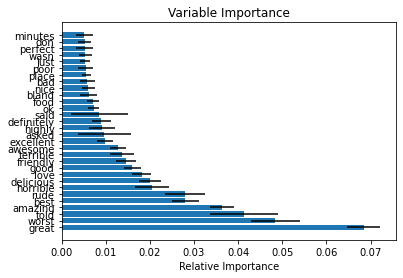

In [ ]:
# Extraction des caractéristiques TF-IDF et utilisation de Random Forest pour la régression

# Transformation de votre corpus d'entraînement en une matrice TF-IDF
X_array = corpus_train_tfidf.toarray()

# Obtention des noms de caractéristiques TF-IDF
features = np.asarray(TFIDF.get_feature_names())

# Création d'un modèle de régression Random Forest
clf = RandomForestRegressor(n_estimators=500, random_state=1, n_jobs=-1)
nb_best = 30

# Entraînement du modèle Random Forest sur les caractéristiques TF-IDF
clf.fit(X_array, y_train)
# Calcul de l'importance des caractéristiques
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
print(features[sorted_idx][:nb_best]) # Affichage des meilleures caractéristiques
padding = np.arange(nb_best) + 0.5
plt.barh(padding, importances[sorted_idx][:nb_best],xerr=std[sorted_idx][:nb_best], align='center')
plt.yticks(padding, features[sorted_idx][:nb_best])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

<h1 align=center><font size = 5 color='blue'>Vectorisation des textes par SVD</font></h1>

In [ ]:

# Truncated SVD pour la réduction de dimension

# Création d'une instance de Truncated SVD avec 100 composantes
SVD = TruncatedSVD(n_components=100)

# Entraînement de Truncated SVD sur la matrice TF-IDF
SVD.fit(corpus_train_tfidf)

# Transformation des données d'entraînement et de test
corpus_train_SVD = SVD.transform(corpus_train_tfidf)
corpus_test_SVD = SVD.transform(corpus_test_tfidf)

In [ ]:
SVD.components_[0,:].shape

(1000,)

In [ ]:
corpus_train_SVD.shape

(31738, 100)

In [ ]:
# Fonction pour afficher les mots clés par concept SVD
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Concept %d: " % topic_idx
        message += " ".join([feature_names[i]+'('+str(np.round(topic[i],2))+')' for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(SVD, TFIDF.get_feature_names(), 5)       # Affichage des mots clés par concept SVD

Concept 0: food(0.23) good(0.22) great(0.21) place(0.21) service(0.17)
Concept 1: food(0.37) good(0.25) great(0.18) chicken(0.15) delicious(0.13)
Concept 2: great(0.58) service(0.19) staff(0.19) friendly(0.19) love(0.14)
Concept 3: pizza(0.45) love(0.31) place(0.31) best(0.12) like(0.1)
Concept 4: pizza(0.75) service(0.21) great(0.15) customer(0.11) crust(0.11)
Concept 5: good(0.55) pizza(0.3) really(0.12) pretty(0.12) service(0.11)
Concept 6: great(0.52) room(0.15) bar(0.11) nice(0.11) burger(0.1)
Concept 7: good(0.49) recommend(0.15) chicken(0.15) car(0.14) friendly(0.14)
Concept 8: staff(0.36) friendly(0.29) room(0.26) hotel(0.21) nice(0.18)
Concept 9: staff(0.38) friendly(0.36) love(0.19) place(0.12) order(0.12)
Concept 10: amazing(0.33) good(0.25) time(0.24) burger(0.24) recommend(0.16)
Concept 11: sushi(0.47) place(0.42) recommend(0.17) service(0.14) rolls(0.12)
Concept 12: love(0.5) service(0.4) burger(0.2) customer(0.19) room(0.18)
Concept 13: love(0.44) chicken(0.21) good(0.2)

In [ ]:
run_models (corpus_train_SVD,y_train,corpus_test_SVD,y_test,algos)

################## RF #############
MAE = 0.793, Accuracy =0.413


array([[ 292,  862,  752,  220,   18],
       [  36,  303,  684,  332,   23],
       [   6,  155,  881,  783,   62],
       [   5,   70,  839, 2262,  485],
       [   7,   90,  692, 3051, 2723]])


################## KNN #############
MAE = 0.872, Accuracy =0.389


array([[ 502,  763,  600,  248,   31],
       [ 103,  340,  527,  356,   52],
       [  43,  251,  759,  720,  114],
       [  26,  202,  992, 1846,  595],
       [  34,  237, 1031, 2623, 2638]])


################## MLP #############
MAE = 0.661, Accuracy =0.516


array([[ 875,  780,  301,  158,   30],
       [ 185,  451,  463,  239,   40],
       [  44,  296,  658,  783,  106],
       [  13,  142,  616, 1942,  948],
       [  16,  123,  354, 1933, 4137]])

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    # Pour chaque concept dans le modèle
    for topic_idx, topic in enumerate(model.components_):
        # Création du message avec le numéro de concept
        message = "Concept #%d: " % topic_idx
        # Tri des indices des mots clés du concept par importance et sélection des n_top_words premiers
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        # Ajout des mots correspondants au message
        message += " ".join([feature_names[i] for i in top_word_indices])
        # Affichage du message
        print(message)
    # Impression d'une ligne vide pour la séparation
    print()

In [ ]:
# Appel de la fonction print_top_words avec un modèle SVD, une liste de noms de fonctionnalités (TFIDF) et 10 mots clés par concept
print_top_words(SVD, TFIDF.get_feature_names(), 10)


<h1 align=center><font size = 5 color='blue'>Vectorisation par Word2Vec entrainé</font></h1>

In [ ]:
## get word2vec for each sentences by using average word embeddings

def word2vec_generator(texts, model, vector_size):
    # Initialisation d'un dictionnaire pour stocker les vecteurs Word2Vec
    dict_word2vec = {}
    for index, word_list in enumerate(texts):
        arr = np.array([0.0 for i in range(0, vector_size)])  # Initialisation du vecteur
        nb_word = 0  # Compteur de mots valides
        for word in word_list:
            try:
                arr += model[word]  # Ajout du vecteur du mot
                nb_word = nb_word + 1
            except KeyError:
                continue  # Ignorer les mots absents du modèle
        if (len(word_list) == 0):
            dict_word2vec[index] = arr
        else:
            dict_word2vec[index] = arr / nb_word  # Moyenne des vecteurs des mots dans la phrase
    df_word2vec = pd.DataFrame(dict_word2vec).T  # Création d'un DataFrame
    return df_word2vec

Training Word2Vec:

In [ ]:
import gensim

In [ ]:
type(corpus_train)

In [ ]:
# Tokenization for Word2Vec training
corpus_train_tokens = pd.Series(corpus_train).apply(lambda line : gensim.utils.simple_preprocess((line)))
corpus_test_tokens = pd.Series(corpus_test).apply(lambda line : gensim.utils.simple_preprocess((line)))

In [ ]:
model_wv_entraine=gensim.models.Word2Vec.load('../models/Word2vec_entraine.h5')

In [ ]:
vector_size=model_wv_entraine.vector_size
# Création de vecteurs Word2Vec pour l'ensemble d'entrainement et de test
corpus_train_wv_entraine=word2vec_generator(corpus_train_tokens,model_wv_entraine.wv,vector_size)
corpus_test_wv_entraine=word2vec_generator(corpus_test_tokens,model_wv_entraine.wv,vector_size)

In [ ]:
corpus_train_wv_entraine.iloc[0,:] # Exemple d'accès à un vecteur Word2Vec

In [ ]:
corpus_train[0] # Exemple d'accès à une phrase brute

In [ ]:
corpus_train_tokens[0] # Exemple d'accès à une phrase tokenisée

In [ ]:
run_models (corpus_train_wv_entraine,y_train,corpus_test_wv_entraine,y_test,algos)      # Exécution des modèles d'apprentissage sur les vecteurs Word2Vec entrainés

<h1 align=center><font size = 5 color='blue'>Vectorisation Word2Vec pre-entrainé de Google</font></h1>

In [ ]:
# Chargement d'un modèle Word2Vec pré-entrainé
model_wv_google=gensim.models.KeyedVectors.load_word2vec_format('../models/GoogleNews-vectors-negative300.bin'
                                                                , binary=True)

In [ ]:
model_wv_google.vector_size

In [ ]:
len(model_wv_google.index_to_key)

In [ ]:
#corpus_train_tokens[0]
vector_size=model_wv_google.vector_size
# Création de vecteurs Word2Vec pour l'ensemble d'entrainement et de test à partir du modèle Google
corpus_train_wv_google=word2vec_generator(corpus_train_tokens,model_wv_google,vector_size)
corpus_test_wv_google=word2vec_generator(corpus_test_tokens,model_wv_google,vector_size)

In [ ]:

# Exécution des modèles d'apprentissage sur les vecteurs Word2Vec pré-entrainés de Google
run_models(corpus_train_wv_google,y_train,corpus_test_wv_google,y_test,algos)

<h1 align=center><font size = 5 color='blue'>Prédiction par LSTM</font></h1>


In [ ]:
# Prédiction par LSTM (Réseau de neurones récurrents)
# Fonction pour convertir une phrase en une séquence d'indices de mots
def to_sequence(index, text):
    indexes = [index[word] for word in text if word in index]
    return indexes

# Création d'un index de mots pour le modèle Word2Vec pré-entrainé de Google
word2idx = {word: idx for idx, word in enumerate(model_wv_google.index_to_key)}

# Conversion des phrases en séquences d'indices de mots
X_train_sequences = [to_sequence(word2idx, x) for x in corpus_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in corpus_test_tokens]

# Vérification des phrases tokenisées et de leurs séquences d'indices
print(corpus_train_tokens.values[0])
print(X_train_sequences[0])

In [ ]:
type(X_train_sequences)

In [ ]:
max([len(X_train_sequences[i]) for i in range(len(X_train_sequences))]) # Utilisation de padding pour avoir des séquences de longueur égale

In [ ]:
# Utilisation de padding pour avoir des séquences de longueur égale
MAX_SEQ_LENGHT=50
N_FEATURES = len(model_wv_google.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

In [ ]:

# Création d'une matrice d'embeddings pour les mots du modèle Word2Vec pré-entrainé
EMBEDDINGS_LEN = model_wv_google.vector_size
embeddings_index = np.zeros((len(model_wv_google.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape


In [ ]:
EMBEDDINGS_LEN = model_wv_google.vector_size
embeddings_index = np.zeros((len(model_wv_google.index_to_key)+1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = model_wv_google[word]
        embeddings_index[idx] = embedding
    except:
        pass

print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

In [ ]:


# Construction d'un modèle LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(len(model_wv_google.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

#model_Bilstm.add(Embedding(30000,
#                    300,  # Embedding size
#                    input_length=50,
#                    trainable=True))

model_lstm.add(LSTM(300, dropout=0.2,return_sequences=True))
model_lstm.add(LSTM(100, dropout=0.2))

#model_lstm.add(Bidirectional(LSTM(128,recurrent_dropout=0.2, return_sequences=True),merge_mode='concat'))
#model_lstm.add(Bidirectional(LSTM(128,recurrent_dropout=0.2, return_sequences=False),merge_mode='concat'))


model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()




In [ ]:
# Entrainement du modèle LSTM
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)  # Evaluation du modèle LSTM sur l'ensemble de test

In [ ]:
prediction=model_lstm.predict(X_test_sequences) # Prédiction avec le modèle LSTM
prediction[prediction<1]=1
prediction[prediction>5]=5
ACC=accuracy_score(y_test,np.round(prediction))
MAE=mean_absolute_error(y_test,prediction)
print('For LSTM MAE = {0:.3f}, Accuracy ={1:.3f}'.format(MAE,ACC))
display(confusion_matrix(y_test,np.round(prediction)))

**Utilisation de la sortie des LSTM dans d'autres modèles supervisés**

In [ ]:
model_lstm.layers

In [ ]:
# Utilisation de la sortie des LSTM dans d'autres modèles supervisés
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)


In [ ]:
corpus_train_lstm.shape

In [ ]:

# Exécution des modèles d'apprentissage sur les caractéristiques extraites des LSTM
run_models(corpus_train_lstm,y_train,corpus_test_lstm,y_test,algos)

**Train Your Own Word2Vec Model**

In [ ]:
# Entrainement de votre propre modèle Word2Vec
import gensim
from gensim.models import Word2Vec

# Tokenization for Word2Vec training
corpus_train_tokens = [gensim.utils.simple_preprocess(doc) for doc in corpus_train]

# Train Word2Vec model
model_wv = Word2Vec(sentences=corpus_train_tokens, vector_size=100, window=5, min_count=1, workers=4)


2. Evaluate the Word2Vec Model

Finding Similar Words:

In [ ]:
# Example of finding similar words
similar_words = word2vec_model.wv.most_similar('example_word', topn=5)
print(similar_words)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Creating word vectors
word_vectors = model_wv.wv
words = list(word_vectors.index_to_key)

# Creating a 2D representation of word vectors using t-SNE
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors.vectors)

# Plotting
plt.figure(figsize=(10, 10))
for i, word in enumerate(words[:50]):  # Plotting only the first 50 words for simplicity
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
plt.show()


In [ ]:
#  checking similarity
print(model_wv.wv.most_similar('example_word'))


3. Use Word2Vec for Text Vectorization

In [ ]:
def vectorize_text(model, corpus):
    vectorized_corpus = []
    for text in corpus:
        tokens = gensim.utils.simple_preprocess(text)
        vector = np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0)
        vectorized_corpus.append(vector)
    return np.array(vectorized_corpus)

corpus_train_vect = vectorize_text(model_wv, corpus_train)
corpus_test_vect = vectorize_text(model_wv, corpus_test)


Vectorization with Word2Vec and TF-IDF Weights


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf.fit(corpus_train)
tfidf_feat = tfidf.get_feature_names_out()

In [ ]:
def vectorize_with_tfidf(model, corpus, tfidf_model, tfidf_features):
    vectorized_corpus = []
    for doc in corpus:
        tokens = gensim.utils.simple_preprocess(doc)
        tfidf_vector = tfidf_model.transform([doc])
        weighted_vector = np.zeros(model.vector_size)
        weight_sum = 0
        for token in tokens:
            if token in model.wv and token in tfidf_features:
                tfidf_weight = tfidf_vector[0, tfidf_features.index(token)]
                weighted_vector += model.wv[token] * tfidf_weight
                weight_sum += tfidf_weight
        if weight_sum != 0:
            weighted_vector /= weight_sum
        vectorized_corpus.append(weighted_vector)
    return np.array(vectorized_corpus)

corpus_train_vect_tfidf = vectorize_with_tfidf(model_wv, corpus_train, tfidf, tfidf_feat)
corpus_test_vect_tfidf = vectorize_with_tfidf(model_wv, corpus_test, tfidf, tfidf_feat)


4. Run Models and Compare Results

In [ ]:
run_models(corpus_train_vect, y_train, corpus_test_vect, y_test, algos)
run_models(corpus_train_vect_tfidf, y_train, corpus_test_vect_tfidf, y_test, algos)


5. Using Pre-trained Word2Vec Model (e.g., Google's Model)

In [ ]:
from gensim.models import KeyedVectors

model_wv_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Now use model_wv_google to vectorize your text data similarly


6. Pipeline Automation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, mean_absolute_error
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure to download these resources if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def text_preprocessor(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=text_preprocessor, max_features=1000, stop_words='english')),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=1))
])


In [ ]:
#Fit the pipeline
pipeline.fit(corpus_train, y_train)

In [ ]:
#Evaluate the pipeline
predictions = pipeline.predict(corpus_test)
MAE = mean_absolute_error(y_test, predictions)
ACC = accuracy_score(y_test, np.round(predictions))

print('Pipeline MAE = {0:.3f}, Accuracy = {1:.3f}'.format(MAE, ACC))